In [1]:
import os
import shutil
from sklearn.metrics import accuracy_score,silhouette_score
from sklearn.cluster import KMeans
import arcpy
import pandas as pd
from sklearn.preprocessing import StandardScaler
from arcpy import env
import numpy as np
import matplotlib.pyplot as plt

In [2]:
env.workspace = r'D:\GEEDOWNLOAD\allfeatures\alldata.gdb'
raster_list = arcpy.ListRasters()

In [3]:
raster_list

['CHILI',
 'ALOS',
 'TMPMIN',
 'TMPMAX',
 'PRE',
 'DEM',
 'SLOPE',
 'RESULT',
 'TMPMEAN']

In [4]:
# 读取各个特征的array
chili_array = arcpy.RasterToNumPyArray('CHILI')
alos_array = arcpy.RasterToNumPyArray('ALOS')
tmpmin_array = arcpy.RasterToNumPyArray('TMPMIN')
tmpmax_array = arcpy.RasterToNumPyArray('TMPMAX')
tmpmean_array = arcpy.RasterToNumPyArray('TMPMEAN')
pre_array = arcpy.RasterToNumPyArray('PRE')
dem_array = arcpy.RasterToNumPyArray('DEM')
slope_array = arcpy.RasterToNumPyArray('SLOPE')

In [41]:
print(chili_array.shape,alos_array.shape,tmpmin_array.shape,tmpmax_array.shape,pre_array.shape,dem_array.shape,slope_array.shape,tmpmean_array.shape)

(17082, 22104) (17082, 22104) (17082, 22104) (17082, 22104) (17082, 22104) (17082, 22104) (17082, 22104) (17082, 22104)


In [5]:
shape1 = dem_array.shape

# 随机生成50000个索引
idx = np.unravel_index(np.random.choice(np.prod(shape1), 50000, replace=False), shape1)

In [6]:
dem_values = dem_array[idx]
pre_values = pre_array[idx]
tmpmax_values = tmpmax_array[idx]
tmpmin_values = tmpmin_array[idx]
chili_values = chili_array[idx]
alos_values = alos_array[idx]
slope_values = slope_array[idx]
tmpmean_values = tmpmean_array[idx]

In [45]:
df = pd.DataFrame({'dem':dem_values,'pre':pre_values,'tmpmean':tmpmax_values})
df1 = pd.DataFrame({'dem':dem_values,'pre':pre_values,'tmpmean':tmpmax_values,'chili':chili_values})

In [ ]:
data = df
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
# 存储每个k值的WSS
wss = []
sil_scores = []  # 存储每个k值的silhouette_score
# 尝试的k的范围
k_range = range(2, 21)  

In [47]:
# 尝试的k的范围
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    wss.append(kmeans.inertia_)

    # 计算silhouette_score并添加到列表中
    sil_score = silhouette_score(data_scaled, kmeans.labels_)
    sil_scores.append(sil_score)

In [48]:
# 计算最优的wss
def find_elbow(wss):
    # 计算每个点与原点和最后一个点的连线之间的距离
    n_points = len(wss)
    coords = np.c_[range(n_points), wss]
    start = np.atleast_2d([0, wss[0]])
    end = np.atleast_2d([n_points - 1, wss[-1]])
    line_vec = end - start
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    vec_from_start = coords - start
    scalar_prod = np.sum(vec_from_start * np.tile(line_vec_norm, (n_points, 1)), axis=1)
    vec_to_line = vec_from_start - np.tile(scalar_prod[:, np.newaxis], (1, 2)) * line_vec_norm
    dist_to_line = np.sqrt(np.sum(vec_to_line ** 2, axis=1))
    # 找到距离最大的点
    idx_elbow = np.argmax(dist_to_line)
    return idx_elbow

better_wss = find_elbow(wss)
print(better_wss)

5


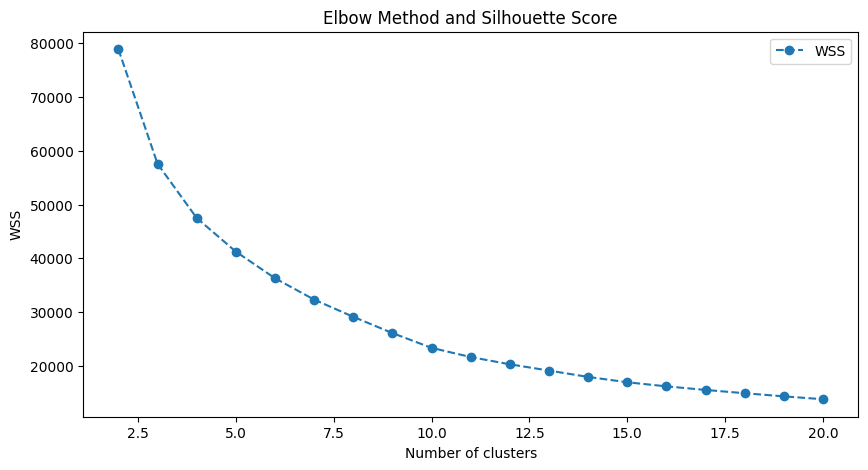

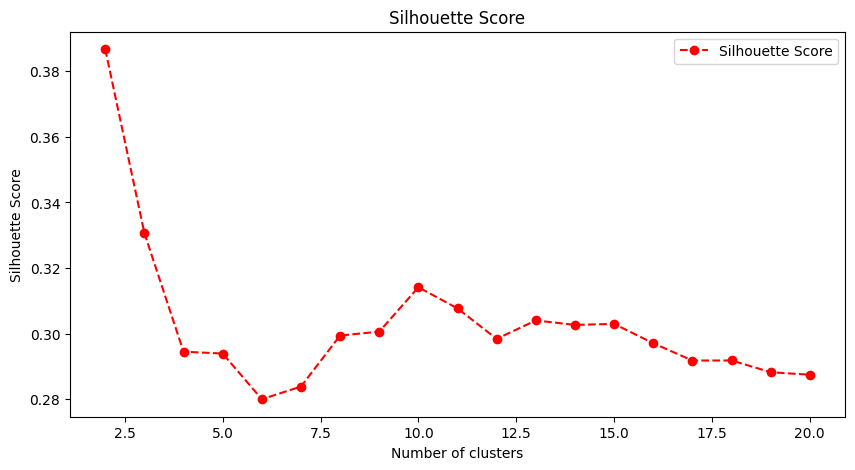

In [49]:
# 画图 - WSS
plt.figure(figsize=(10,5))
plt.plot(k_range, wss, marker='o', linestyle='--', label='WSS')
plt.title('Elbow Method and Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('WSS')
plt.legend()
plt.show()

# 画图 - Silhouette Score
plt.figure(figsize=(10,5))
plt.plot(k_range, sil_scores, marker='o', linestyle='--', color='red', label='Silhouette Score')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.show()

In [50]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(data_scaled)

KMeans(n_clusters=5, random_state=42)

In [51]:
kmeans.labels_.size

50000

In [52]:
df['label'] = list(kmeans.labels_)

In [53]:
df

,dem,pre,tmpmean,label
0,800,89,198,0
1,873,94,198,0
2,1312,95,184,0
3,588,99,209,3
4,2066,84,190,2
...,...,...,...,...
49995,1672,78,176,2
49996,807,103,198,1
49997,474,118,223,4
49998,895,106,240,4


In [54]:
df1['label'] = list(kmeans.labels_)
df1

,dem,pre,tmpmean,chili,label
0,800,89,198,229,0
1,873,94,198,201,0
2,1312,95,184,250,0
3,588,99,209,229,3
4,2066,84,190,234,2
...,...,...,...,...,...
49995,1672,78,176,208,2
49996,807,103,198,193,1
49997,474,118,223,174,4
49998,895,106,240,175,4


In [55]:
df1.to_csv(r"C:\Users\Runker\Desktop\result\result.csv")

In [7]:
dem_flatten = dem_array.flatten()
pre_flatten = pre_array.flatten()
# chili_flatten = chili_array.flatten()
# # alos_flatten = alos_array.flatten()
# # slope_flatten = slope_array.flatten()
# tmpmax_flatten = tmpmax_array.flatten()
# tmpmin_flatten = tmpmin_array.flatten()
tmpmean_flatten = dem_array.flatten()

In [8]:
predictor_data = pd.DataFrame({'dem':dem_flatten,'pre':pre_flatten,'tmpmean':tmpmean_flatten})

In [11]:
# 标准化
scaler = StandardScaler()
scaler_predictor_data = scaler.fit_transform(predictor_data)
scaler_predictor_data

array([[ 0.18258835,  1.37361909,  0.18258835],
       [ 0.18258835,  1.37361909,  0.18258835],
       [ 0.171352  ,  1.37361909,  0.171352  ],
       ...,
       [-1.70699109,  3.73529944, -1.70699109],
       [-1.70137291,  3.73529944, -1.70137291],
       [-1.69762746,  3.73529944, -1.69762746]])

In [12]:
print(type(scaler_predictor_data)),print(scaler_predictor_data.dtype)

<class 'numpy.ndarray'>
float64


(None, None)

In [13]:
scaler_predictor_data_s = scaler_predictor_data.astype(np.float16)

In [14]:
scaler_predictor_data_s

array([[ 0.1826,  1.374 ,  0.1826],
       [ 0.1826,  1.374 ,  0.1826],
       [ 0.1714,  1.374 ,  0.1714],
       ...,
       [-1.707 ,  3.734 , -1.707 ],
       [-1.701 ,  3.734 , -1.701 ],
       [-1.697 ,  3.734 , -1.697 ]], dtype=float16)

In [16]:
# 预测标签
kmeans = KMeans(n_clusters=5, random_state=42)
predictor_value = kmeans.fit_predict(scaler_predictor_data_s)


In [17]:
# 重塑形状
raster_array = np.reshape(predictor_value,dem_array.shape)
raster_array

array([[2, 2, 2, ..., 4, 4, 4],
       [2, 2, 2, ..., 4, 4, 4],
       [2, 2, 2, ..., 4, 4, 4],
       ...,
       [1, 1, 1, ..., 4, 4, 4],
       [1, 1, 1, ..., 4, 4, 4],
       [1, 1, 1, ..., 4, 4, 4]])

In [18]:
# 空间范围
env.extent = "DEM"

In [19]:
# 使用Describe函数获取栅格的描述
raster_desc = arcpy.Describe('DEM')

# 获取像元宽度和高度
cell_width = raster_desc.meanCellWidth
cell_height = raster_desc.meanCellHeight
cell_width,cell_height
# 获取左下角坐标
lower_left_corner = raster_desc.extent.lowerLeft


In [20]:
# 将预测结果输出为栅格数据
out_raster = arcpy.NumPyArrayToRaster(
    raster_array,
    lower_left_corner,
    cell_width,
    cell_height
)
out_raster.save("RESULT_5")
print("完成")


完成
